# Identifying Location Trends in Foursquare

In [182]:
from IPython.display import HTML
HTML('<iframe src="http://en.wikipedia.org/wiki/Foursquare" width=100% height=350></iframe>')

### Task:

* Find trending locations on Foursquare by comparing some metrics at t1 to t0
* Find metrics that could be useful
* Map the data

## Initialization

First, you have to find your access tokens to use the Foursquare API with reasonable rate limits.

If you have an access token, you can use that, otherwise register an app an use the client id and secret for the following steps. https://de.foursquare.com/developers/register or you create a temporary access token via the API tryout section https://developer.foursquare.com/docs/explore#req=venues/search%3Fll%3D40.7,-74

In [6]:
import foursquare
import pandas as pd
import configparser

#ACCESS_TOKEN = ""
#client = foursquare.Foursquare(access_token=ACCESS_TOKEN)

#CLIENT_ID = ""
#CLIENT_SECRET = ""

config = configparser.ConfigParser()
config.read('config.ini')

CLIENT_ID = config['DEFAULT']['CLIENT_ID']
CLIENT_SECRET = config['DEFAULT']['CLIENT_SECRET']

client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

In [3]:
client.venues("4ade0ccef964a520246921e3")

{'venue': {'attributes': {'groups': [{'count': 5,
     'items': [{'displayName': 'Credit Cards', 'displayValue': 'No'}],
     'name': 'Credit Cards',
     'summary': 'No Credit Cards',
     'type': 'payments'},
    {'count': 1,
     'items': [{'displayName': 'Wi-Fi', 'displayValue': 'Free'}],
     'name': 'Wi-Fi',
     'summary': 'Free Wi-Fi',
     'type': 'wifi'}]},
  'beenHere': {'count': 0,
   'lastCheckinExpiredAt': 0,
   'marked': False,
   'unconfirmedCount': 0},
  'bestPhoto': {'createdAt': 1363090995,
   'height': 720,
   'id': '513f1e33e4b03b7cb295151e',
   'prefix': 'https://igx.4sqi.net/img/general/',
   'source': {'name': 'Foursquare for iOS',
    'url': 'https://foursquare.com/download/#/iphone'},
   'suffix': '/50244804_FsZKMaiO5y7OcJzScc-9zaQYEVlvoSzGxrE2t6N8K3I.jpg',
   'visibility': 'public',
   'width': 720},
  'canonicalUrl': 'https://foursquare.com/v/marienplatz/4ade0ccef964a520246921e3',
  'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/p

## Fetching the Foursquare location links

1. Starting at some Stuttgart locations as seed venue
2. Fetching the 5 next venues (from API nextvenues, see: https://developer.foursquare.com/docs/api/venues/nextvenues)
3. For each of the 5 venues fetch the 5 next venues
4. Repeat until saturation (no new locations)

In [202]:
bbox = [9.0,48.5,9.5,49.0] # bounding box for Stuttgart
#bbox = [11.109872,47.815652,12.068588,48.397136] # bounding box for Munich
#bbox = [13.088400,52.338120,13.761340,52.675499] # bounding box for Berlin
#bbox = [5.866240,47.270210,15.042050,55.058140] # bounding box for Germany

In [314]:
new_crawl = [] # list of locations to be crawled
done = [] # list of crawled locations
links = [] # list of tuples that represent links between locations
venues = pd.DataFrame() # dictionary of locations id => meta-data on location

Set seed values for Schlossplatz, Airport, Central Station, Outlet City Metzingen, Killesberg, Wilhelma.

Depth is the number of recursive crawling processes.

In [315]:
to_crawl = ["4b9d1894f964a5203a8f36e3", "4b1ccba5f964a520cb0924e3", "4b29f103f964a52049a424e3", 
            "4b9230c7f964a5208beb33e3", "4bcb059f0687ef3b89e2dccc", "4b5b1161f964a520eae128e3"]
depth = 25

In [310]:
old_venues = venues.index

In [322]:
to_crawl = [i for i in old_venues if i not in venues.index]

In [323]:
for i in range(depth):
    new_crawl = []
    print ("Step " + str(i) + ": " + str(len(venues)) + " locations and " + str(len(links)) + " links. " + str(len(to_crawl)) + " venues to go.")
    for v in to_crawl:
        if v not in venues:
            res = client.venues(v)
            if "rating" in res["venue"]:
                rating = res["venue"]["rating"]
            else:
                rating = NaN
            venues = venues.append(pd.DataFrame({
                "name":res["venue"]["name"],
                "users":res["venue"]["stats"]["usersCount"],
                "checkins":res["venue"]["stats"]["checkinsCount"],
                "tips":res["venue"]["stats"]["tipCount"],
                "lat":res["venue"]["location"]["lat"], 
                "lng":res["venue"]["location"]["lng"],
                "rating":rating
            }, index=[v]))
        next_venues = client.venues.nextvenues(v)
        for nv in next_venues['nextVenues']['items']:
            if ((nv["location"]["lat"] > bbox[1]) & (nv["location"]["lat"] < bbox[3]) & 
                (nv["location"]["lng"] > bbox[0]) & (nv["location"]["lng"] < bbox[2])):
                if nv["id"] not in venues:
                    venues = venues.append(pd.DataFrame({"name":nv["name"],"users":nv["stats"]["usersCount"],
                    "checkins":nv["stats"]["checkinsCount"], "lat":nv["location"]["lat"], 
                    "lng":nv["location"]["lng"]}, index=[nv["id"]]))
                if (nv["id"] not in done) & (nv["id"] not in to_crawl) & (nv["id"] not in new_crawl):
                    new_crawl.append(nv["id"])
                links.append((v, nv["id"]))
        done.append(v)
    to_crawl = new_crawl

Step 0: 161 locations and 607 links. 205 venues to go.
Step 1: 753 locations and 994 links. 0 venues to go.
Step 2: 753 locations and 994 links. 0 venues to go.
Step 3: 753 locations and 994 links. 0 venues to go.
Step 4: 753 locations and 994 links. 0 venues to go.
Step 5: 753 locations and 994 links. 0 venues to go.
Step 6: 753 locations and 994 links. 0 venues to go.
Step 7: 753 locations and 994 links. 0 venues to go.
Step 8: 753 locations and 994 links. 0 venues to go.
Step 9: 753 locations and 994 links. 0 venues to go.
Step 10: 753 locations and 994 links. 0 venues to go.
Step 11: 753 locations and 994 links. 0 venues to go.
Step 12: 753 locations and 994 links. 0 venues to go.
Step 13: 753 locations and 994 links. 0 venues to go.
Step 14: 753 locations and 994 links. 0 venues to go.
Step 15: 753 locations and 994 links. 0 venues to go.
Step 16: 753 locations and 994 links. 0 venues to go.
Step 17: 753 locations and 994 links. 0 venues to go.
Step 18: 753 locations and 994 links

## Generating the network

We're importing networkx to build the network out of our crawled venues (= nodes) and links between them.

In [389]:
venues = venues.reset_index().drop_duplicates(subset=['index'],keep='last').set_index('index')
venues.head()

checkins        lat       lng  \
index                                                     
4b82d6a3f964a52042e830e3       385  48.811035  9.176374   
4b97859cf964a520220735e3      1141  48.773343  9.173337   
4bd81d4ce914a593776f52fa      1205  48.693331  9.197586   
4b657ffcf964a52081f22ae3       917  48.778984  9.180367   
4bcd5736b6c49c74f04a9591       974  48.745719  9.108037   

                                           name  rating  tips  users  \
index                                                                  
4b82d6a3f964a52042e830e3      Messehotel Europe     4.7   7.0    517   
4b97859cf964a520220735e3             McDonald's     5.1   6.0    757   
4bd81d4ce914a593776f52fa             McDonald's     5.1   7.0   1513   
4b657ffcf964a52081f22ae3      Cafe Künstlerbund     5.3  19.0    769   
4bcd5736b6c49c74f04a9591  Commundo Tagungshotel     5.3   5.0    671   

                          pagerank  betweenness            x            y  
index                                                                      
4b82d6a3f964a52042e830e3  0.000435      0.00000   420.120413 -1744.251622  
4b97859cf964a520220735e3  0.000618      0.00002   269.211000  1097.431587  
4bd81d4ce914a593776f52fa  0.000513      0.00000  1474.244414  7129.811258  
4b657ffcf964a52081f22ae3  0.000578      0.00031   618.573893   672.165939  
4bcd5736b6c49c74f04a9591  0.000435      0.00000 -2975.715964  3180.104306

In [308]:
venues.to_csv('venues_stg.csv')

In [325]:
labels = venues["name"].to_dict()

In [391]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(venues.index)
for f,t in links:
    G.add_edge(f, t)
for i in range(len(venues["name"])):
    G.node[venues.index[i]]['label'] = venues["name"][i]
    if math.isnan(venues["rating"][i]) == False:
        G.node[venues.index[i]]['rating'] = float(venues["rating"][i])
    else:
        G.node[venues.index[i]]['rating'] = 0

In [392]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 366\nNumber of edges: 939\nAverage in degree:   2.5656\nAverage out degree:   2.5656'

Calculate some useful metrics:

* Betweenness Centrality: Number of shortest paths in the network that pass through this node <img src="http://upload.wikimedia.org/math/b/3/0/b30e5d1ded3e018f8ed080b9b09876e9.png">
* Page Rank: Random Walk through city <img src="http://upload.wikimedia.org/math/a/c/4/ac48cfa215bf51c9cab4b92df790674b.png">

In [379]:
pagerank = nx.pagerank(G,alpha=0.9)
betweenness = nx.betweenness_centrality(G)

venues['pagerank'] = [pagerank[n] for n in venues.index]
venues['betweenness'] = [betweenness[n] for n in venues.index]

### Plot some stats

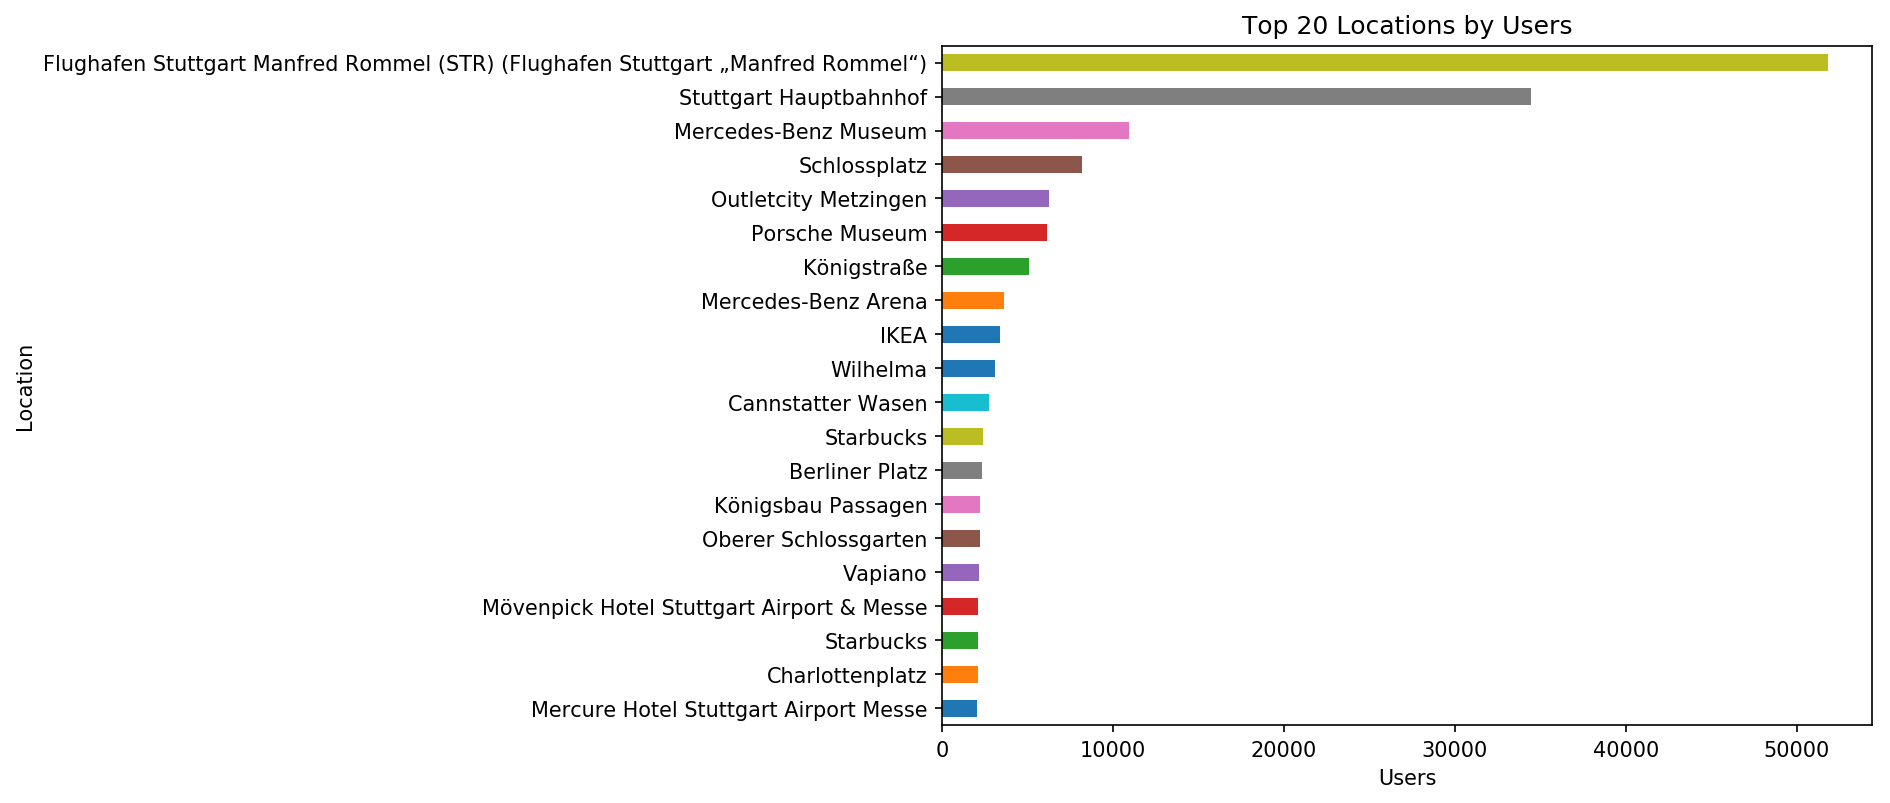

In [329]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)
venues.sort_values('users', inplace=True)
venues.set_index('name')[-20:].users.plot(kind='barh')
ax.set_ylabel('Location')
ax.set_xlabel('Users')
ax.set_title('Top 20 Locations by Users')
plt.show()

In [388]:
venues.sort_values('rating', inplace=True)
venues.head()

checkins        lat       lng  \
index                                                     
4b82d6a3f964a52042e830e3       385  48.811035  9.176374   
4b97859cf964a520220735e3      1141  48.773343  9.173337   
4bd81d4ce914a593776f52fa      1205  48.693331  9.197586   
4b657ffcf964a52081f22ae3       917  48.778984  9.180367   
4bcd5736b6c49c74f04a9591       974  48.745719  9.108037   

                                           name  rating  tips  users  \
index                                                                  
4b82d6a3f964a52042e830e3      Messehotel Europe     4.7   7.0    517   
4b97859cf964a520220735e3             McDonald's     5.1   6.0    757   
4bd81d4ce914a593776f52fa             McDonald's     5.1   7.0   1513   
4b657ffcf964a52081f22ae3      Cafe Künstlerbund     5.3  19.0    769   
4bcd5736b6c49c74f04a9591  Commundo Tagungshotel     5.3   5.0    671   

                          pagerank  betweenness            x            y  
index                                                                      
4b82d6a3f964a52042e830e3  0.000435      0.00000   420.120413 -1744.251622  
4b97859cf964a520220735e3  0.000618      0.00002   269.211000  1097.431587  
4bd81d4ce914a593776f52fa  0.000513      0.00000  1474.244414  7129.811258  
4b657ffcf964a52081f22ae3  0.000578      0.00031   618.573893   672.165939  
4bcd5736b6c49c74f04a9591  0.000435      0.00000 -2975.715964  3180.104306

/Users/koehler/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


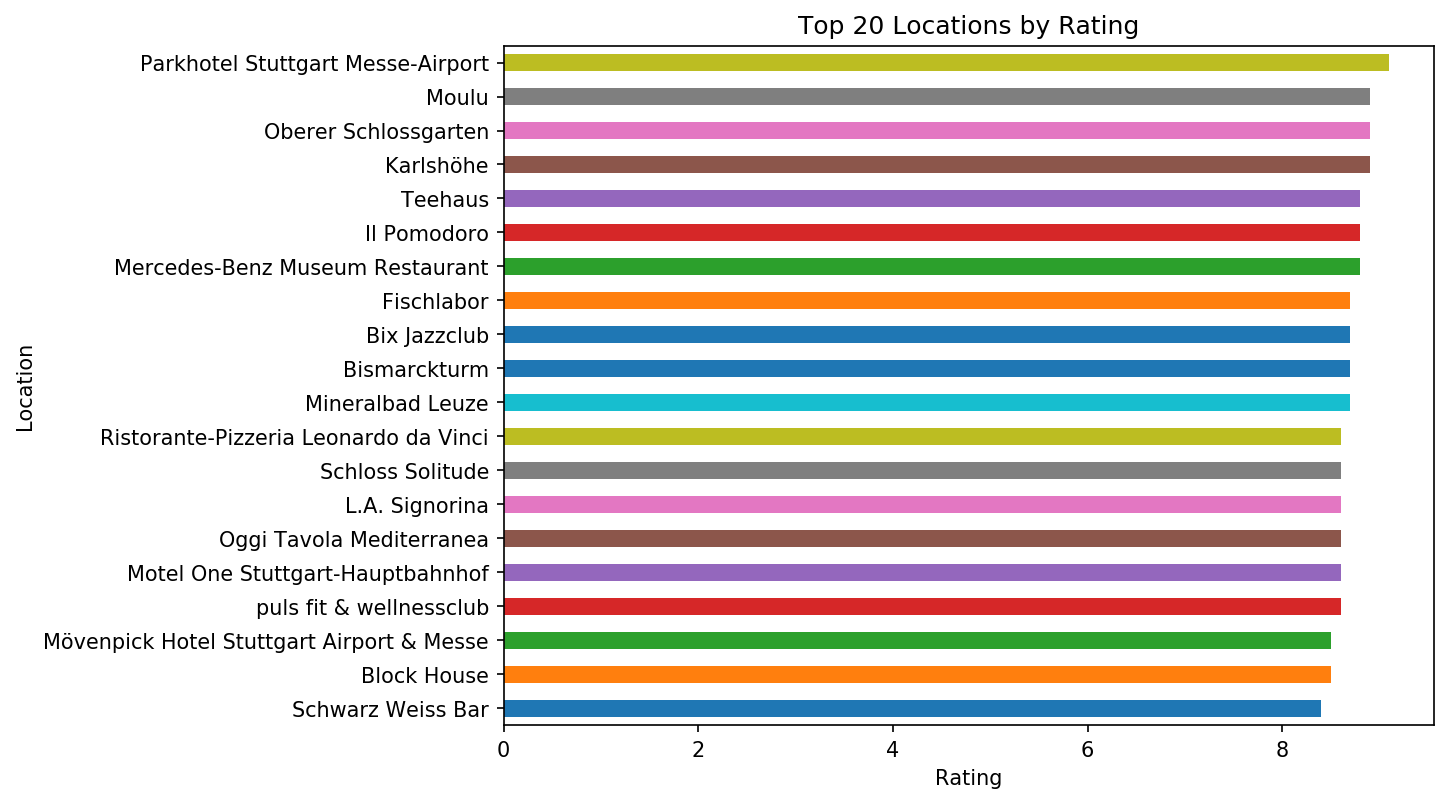

In [347]:
rated_venues = venues.dropna(axis=0, subset=["rating"])
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)
rated_venues.sort_values('rating', inplace=True)
rated_venues.set_index('name')[-20:].rating.plot(kind='barh')
ax.set_ylabel('Location')
ax.set_xlabel('Rating')
ax.set_title('Top 20 Locations by Rating')
plt.show()

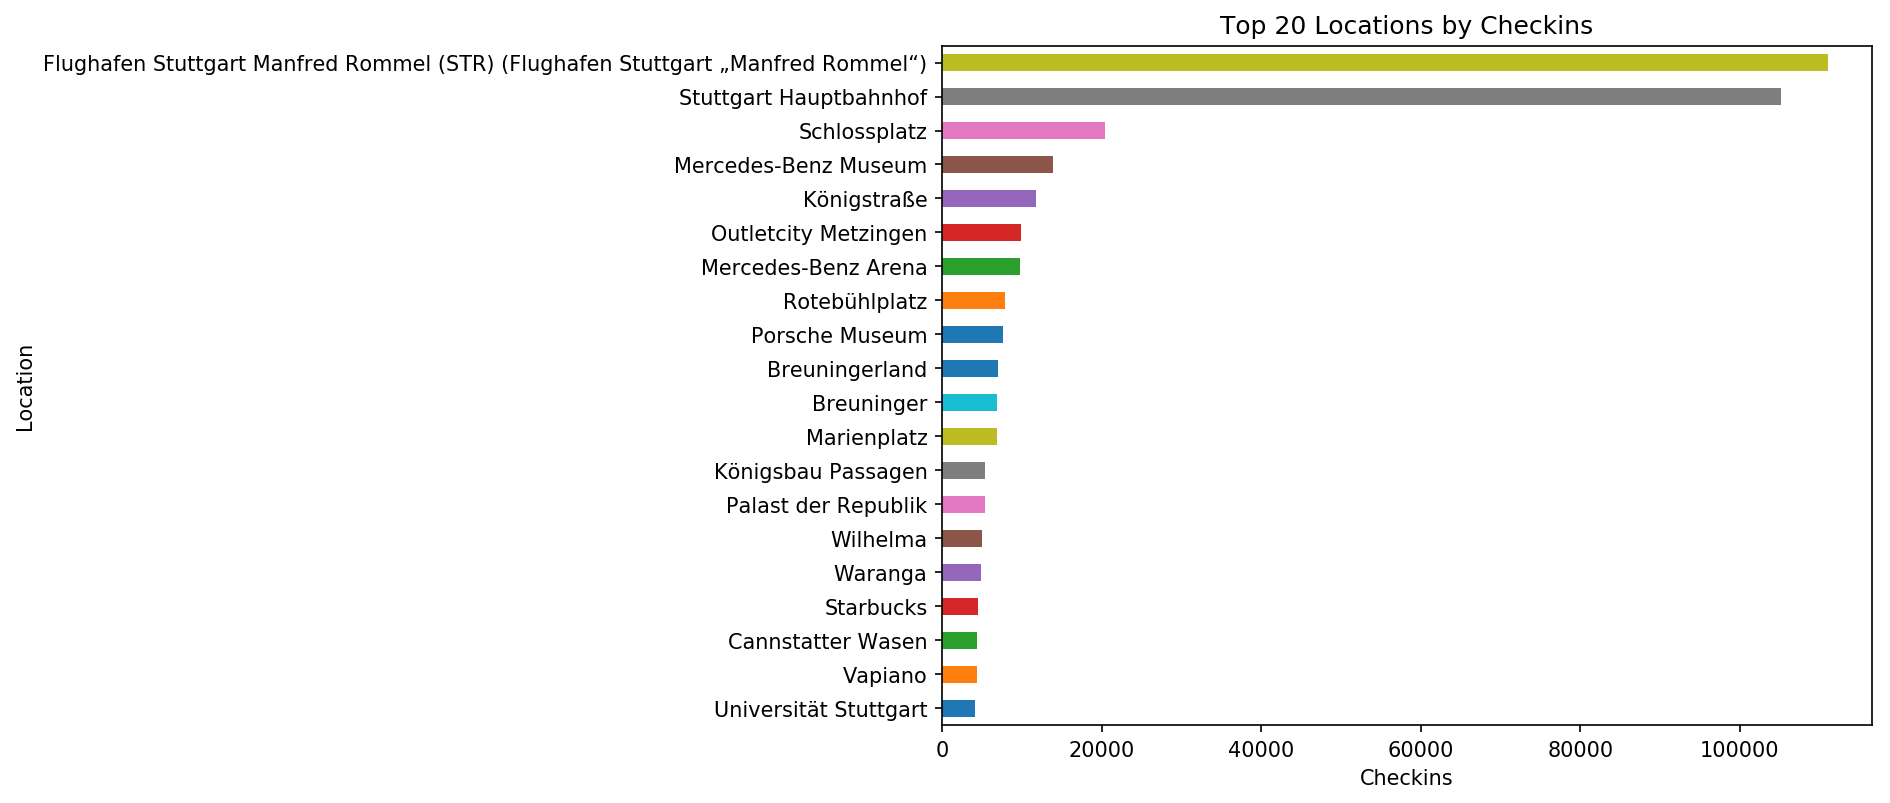

In [301]:
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)
venues.sort_values('checkins', inplace=True)
venues.set_index('name')[-20:].checkins.plot(kind='barh')
ax.set_ylabel('Location')
ax.set_xlabel('Checkins')
ax.set_title('Top 20 Locations by Checkins')
plt.show()

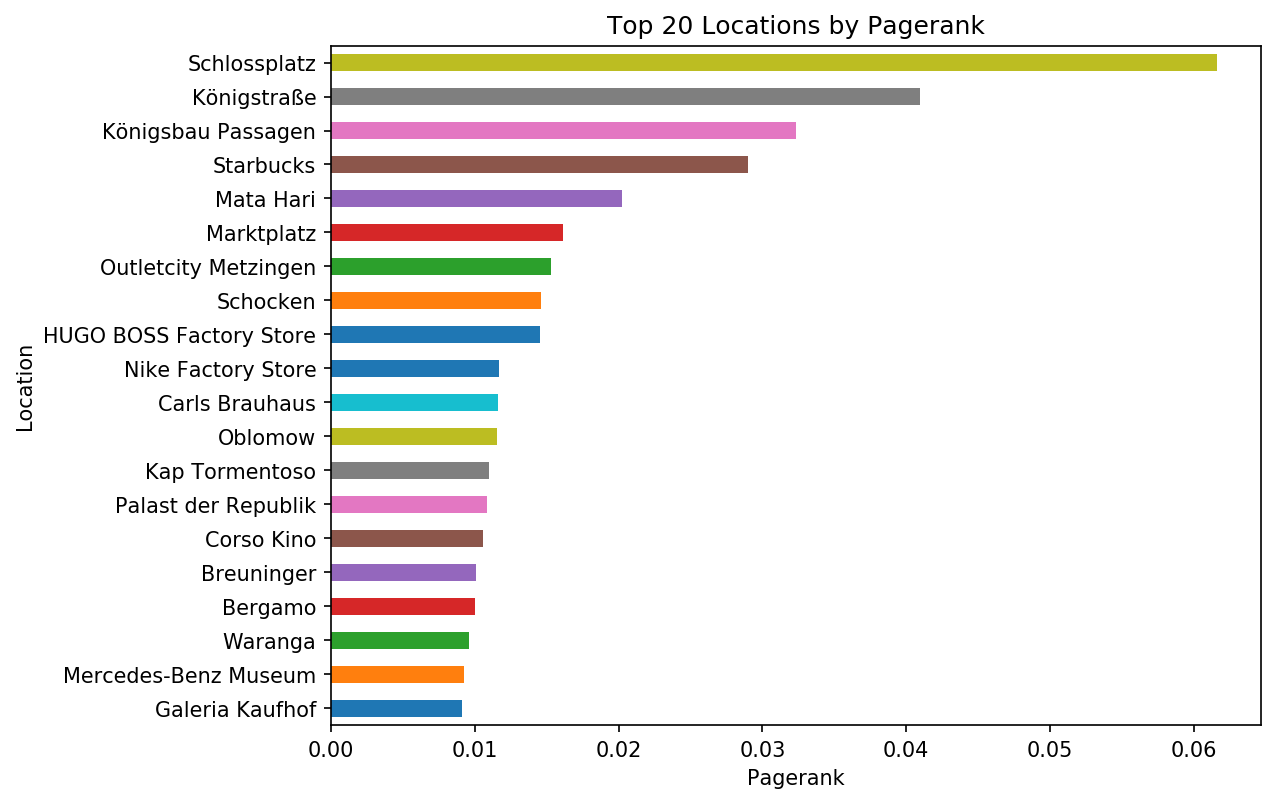

In [302]:
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)
venues.sort_values('pagerank', inplace=True)
venues.set_index('name')[-20:].pagerank.plot(kind='barh')
ax.set_ylabel('Location')
ax.set_xlabel('Pagerank')
ax.set_title('Top 20 Locations by Pagerank')
plt.show()

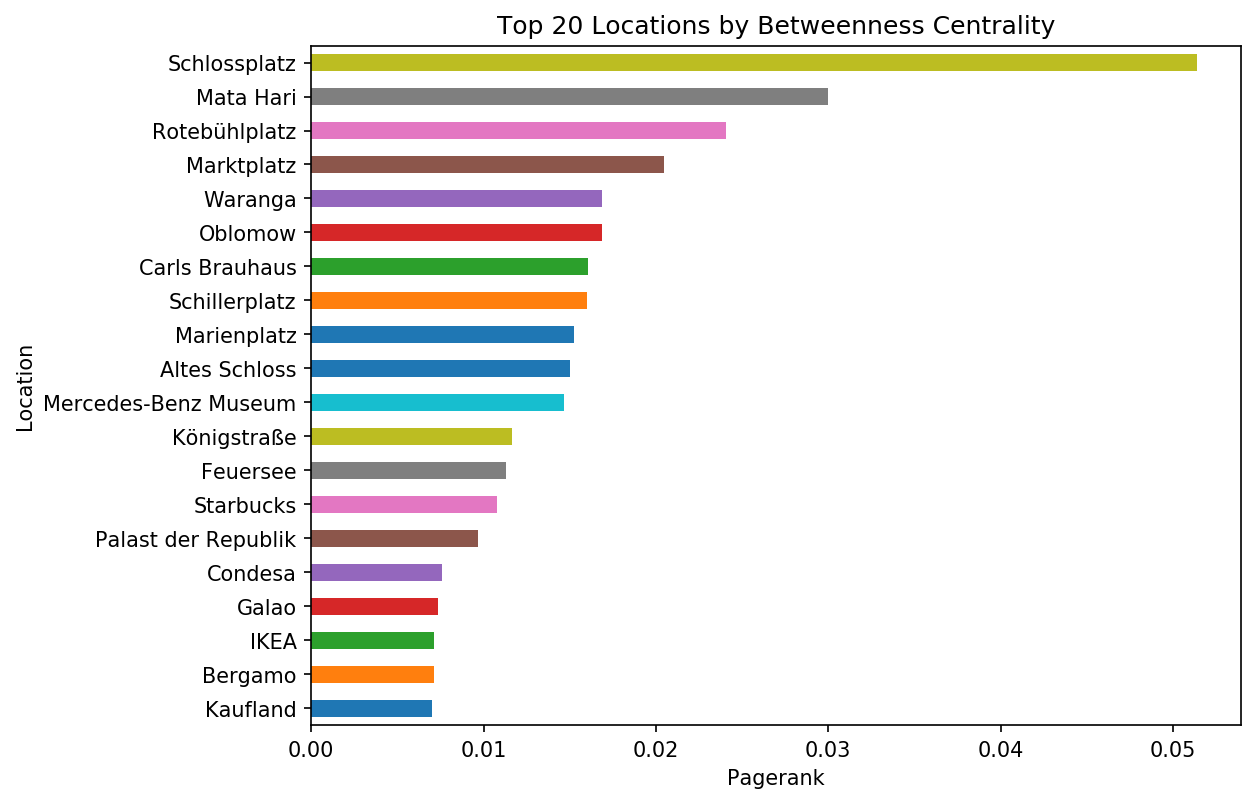

In [303]:
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)
venues.sort_values('betweenness', inplace=True)
venues.set_index('name')[-20:].betweenness.plot(kind='barh')
ax.set_ylabel('Location')
ax.set_xlabel('Pagerank')
ax.set_title('Top 20 Locations by Betweenness Centrality')
plt.show()

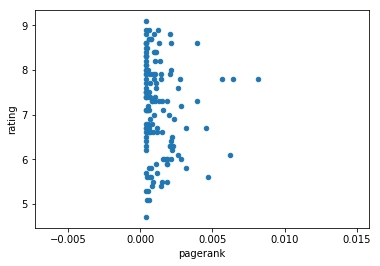

In [369]:
rated_venues.plot.scatter("pagerank", "rating")

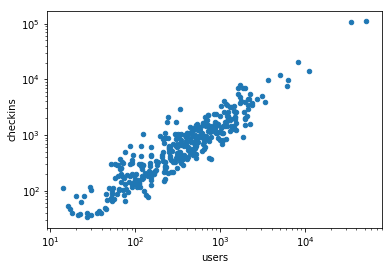

In [370]:
venues.plot.scatter("users", "checkins", loglog=True)

### Plot the hotspots of the city on a map

Rescaling the geodata to fit our basemap:<img src="http://upload.wikimedia.org/math/7/6/5/76512b142c1b7e27e8a7e7eb1fc11225.png">

In [154]:
bbox_map = [9.167919158935549,48.77179702776337,9.201908111572267,48.78789922657753]
img_width = 1689
img_height = 1214

In [380]:
venues['x'] = img_width*(venues.lng - bbox_map[0]) / (bbox_map[2] - bbox_map[0])
venues['y'] = img_height - img_height * (venues.lat - bbox_map[1]) / (bbox_map[3] - bbox_map[1])
venues.sort_values('pagerank', ascending=False)[['name', 'x', 'y', 'pagerank', 'lat', 'lng']][:10]
venues_draw = venues[(venues.x >= 0) & (venues.y >= 0)]
venues_draw.head()[['name', 'x', 'y']]

name           x  \
index                                                                     
4d08936c00e6b1f708290ed7  Parkhotel Stuttgart Messe-Airport   10.147642   
4e018b96b61c90045005655b               Oberer Schlossgarten  721.559575   
4bf295de55c7c9b66a3e6204                            Teehaus  732.229745   
4bc77a468b7c9c744e8836cf                       Bix Jazzclub  575.237237   
4ebab9ff61af8c1a07cae83e   Motel One Stuttgart-Hauptbahnhof  552.277581   

                                    y  
index                                  
4d08936c00e6b1f708290ed7  7248.388566  
4e018b96b61c90045005655b   595.361964  
4bf295de55c7c9b66a3e6204  1770.190714  
4bc77a468b7c9c744e8836cf  1109.912777  
4ebab9ff61af8c1a07cae83e   439.341058

In [381]:
print("Min and max values:")
print([min(venues.lng), min(venues.lat), max(venues.lng), max(venues.lat)])

Min and max values:
[8.972808692637672, 48.53433213486617, 9.33648564832641, 48.95615334379254]


Plotting the data on an OpenStreetMap basemap that can be retrieved by

`render.openstreetmap.org/cgi-bin/export?bbox=8.972808692637672,48.53433213486617,9.284817910183758,48.95615334379254&scale=91159&format=png`

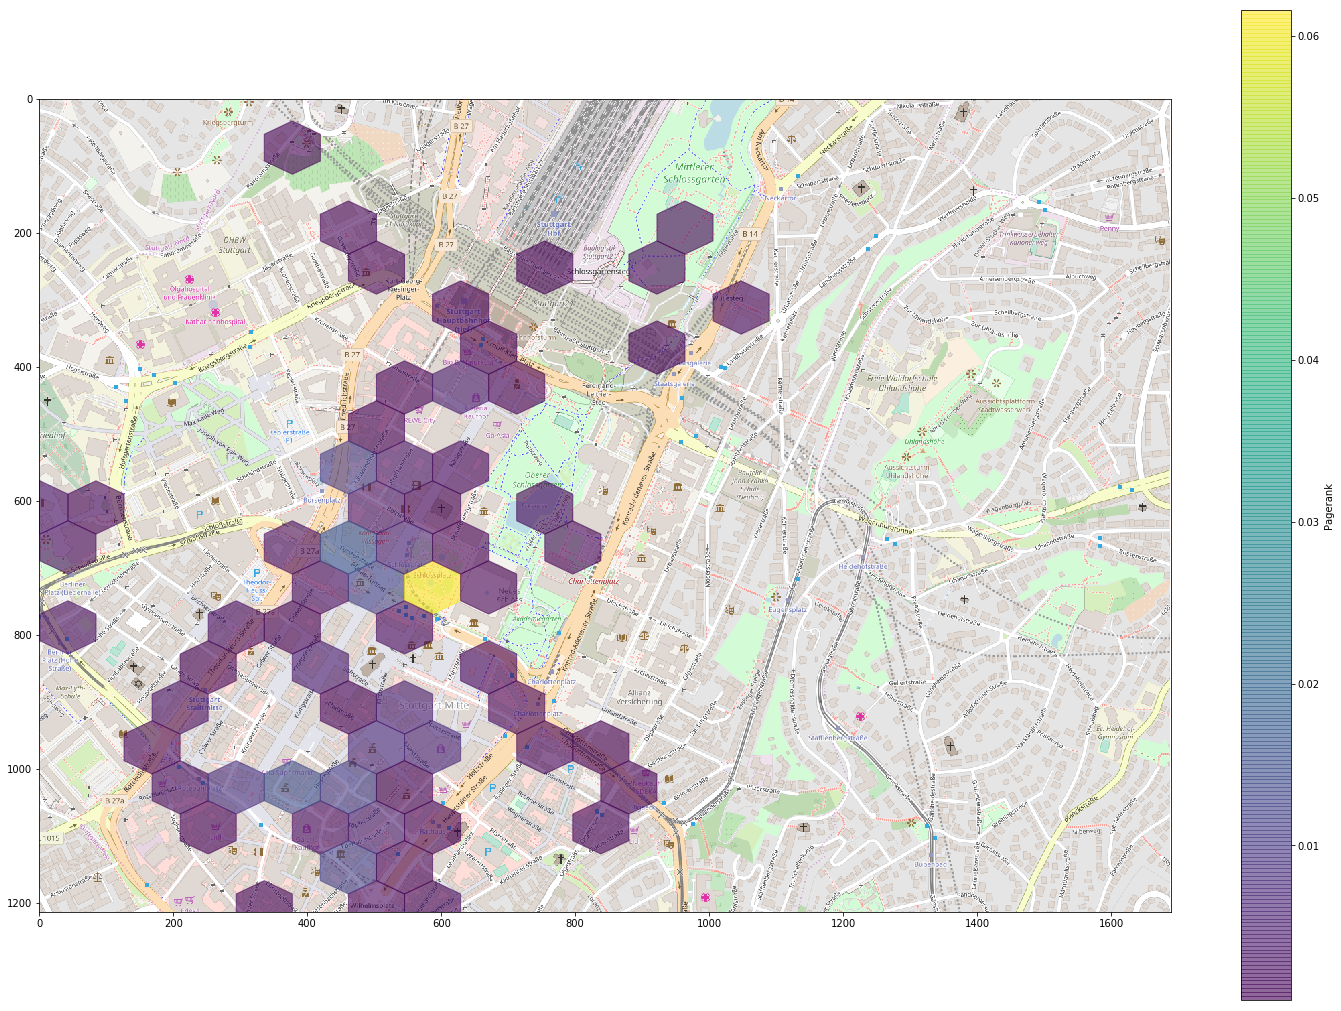

In [382]:
figure(figsize=(25.34,18.21))
img = imread("stuttgart_center.png")
plt.imshow(img, zorder=0, alpha=0.8)
plt.hexbin(venues_draw.x, venues_draw.y, gridsize=(100,160), C=venues_draw.pagerank, reduce_C_function = np.mean, zorder=1, alpha=0.6)
plt.axis([0,img_width,img_height,0])
cb = plt.colorbar()
cb.set_label('Pagerank')
plt.show()

Visualize the network

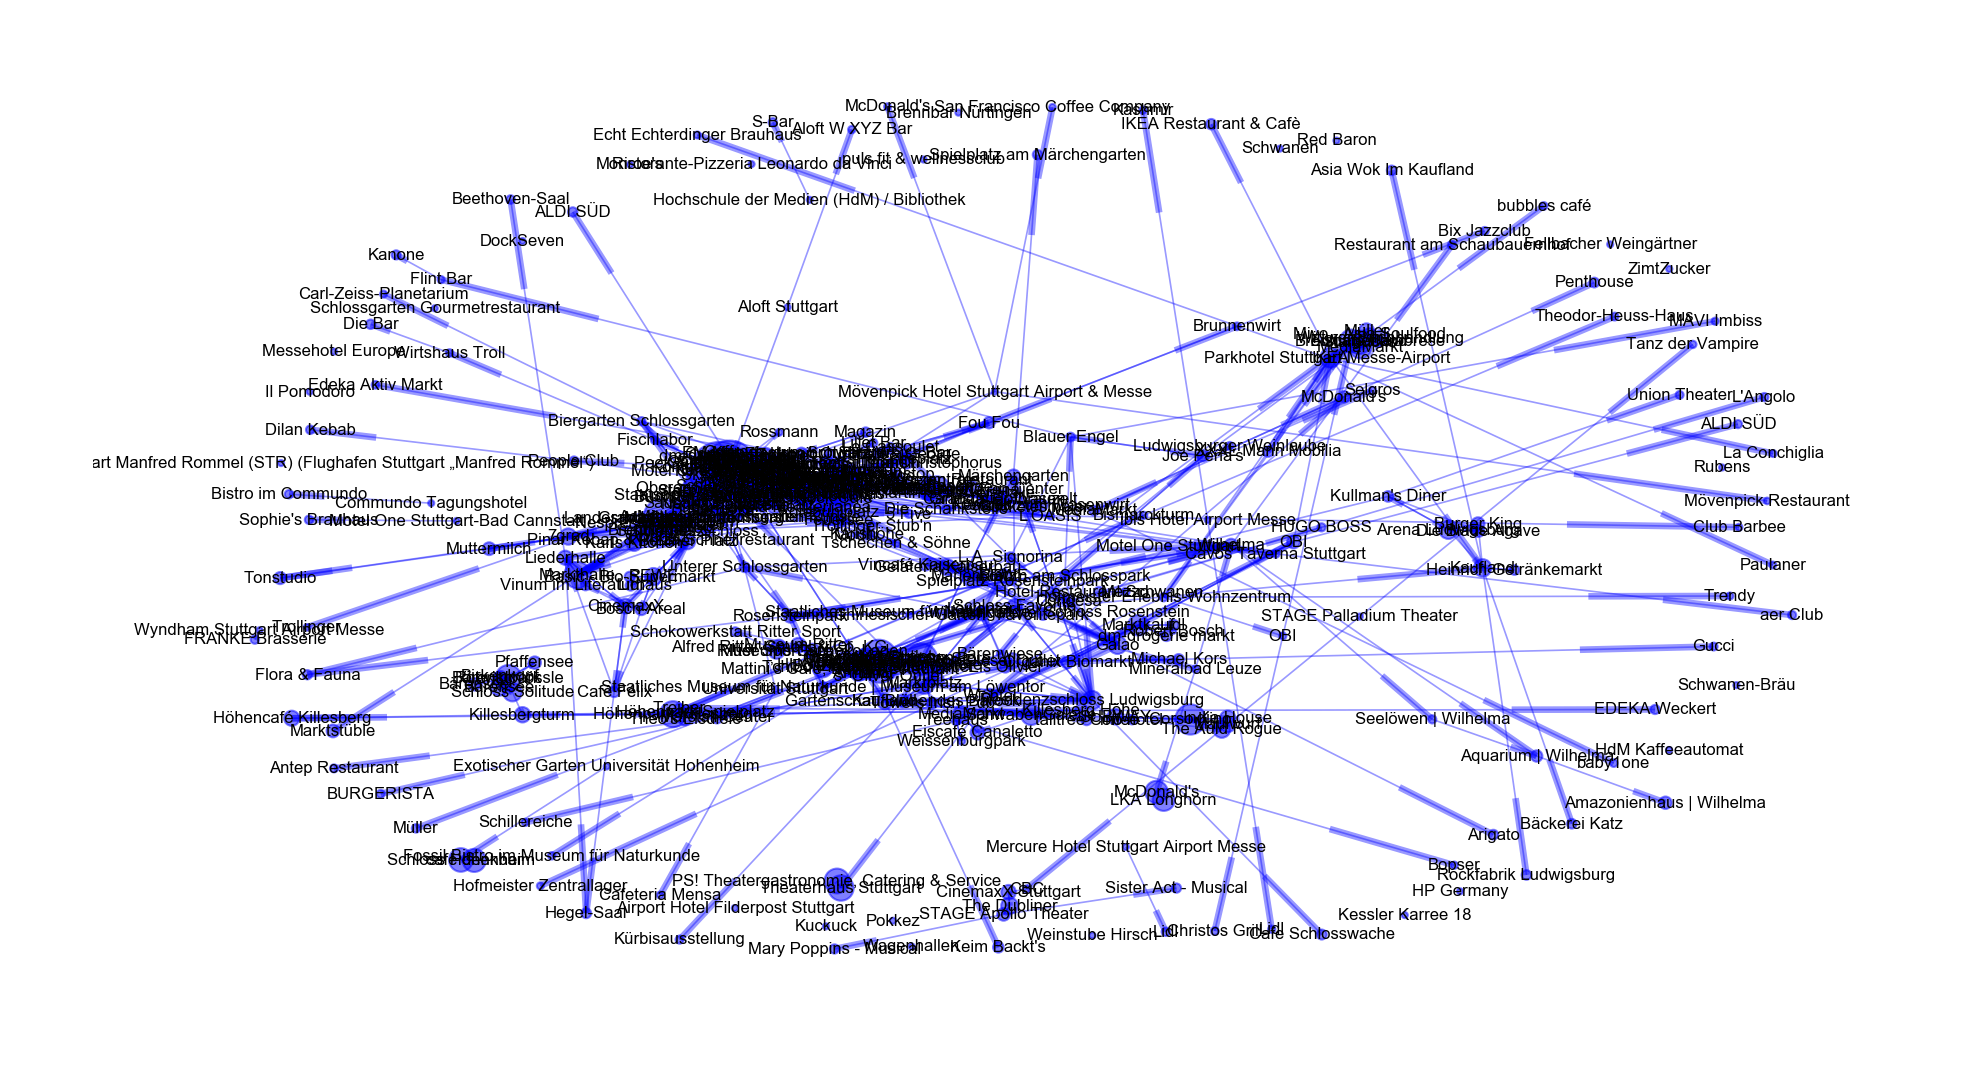

In [383]:
fig = plt.figure(figsize=(16, 9), dpi=150)
graph_pos=nx.spring_layout(G)
nodesize = [20000*n for n in pagerank.values()]
nx.draw_networkx_nodes(G,graph_pos,node_size=nodesize, alpha=0.5, node_color='blue')
nx.draw_networkx_edges(G,graph_pos,width=0.8, alpha=0.4,edge_color='blue')
nx.draw_networkx_labels(G, graph_pos, labels=labels, font_size=8, font_family='Arial')
plt.axis('off')
plt.show()

Finally, save the network for further analysis e.g. in Gephi

In [393]:
nx.write_graphml(G, "./fs_loc_stg_jan18.graphml")

## Trend Research with location data

Loading historical location data gathered with the same method in May 2014

In [261]:
F = nx.read_graphml("fs_loc_muc_l_may14.graphml")

In [262]:
pagerank_old = nx.pagerank(F,alpha=0.9,max_iter=200)
betweenness_old = nx.betweenness_centrality(F)

venues_old['pagerank'] = [pagerank_old[n] for n in venues_old.index]
venues_old['betweenness'] = [betweenness_old[n] for n in venues_old.index]

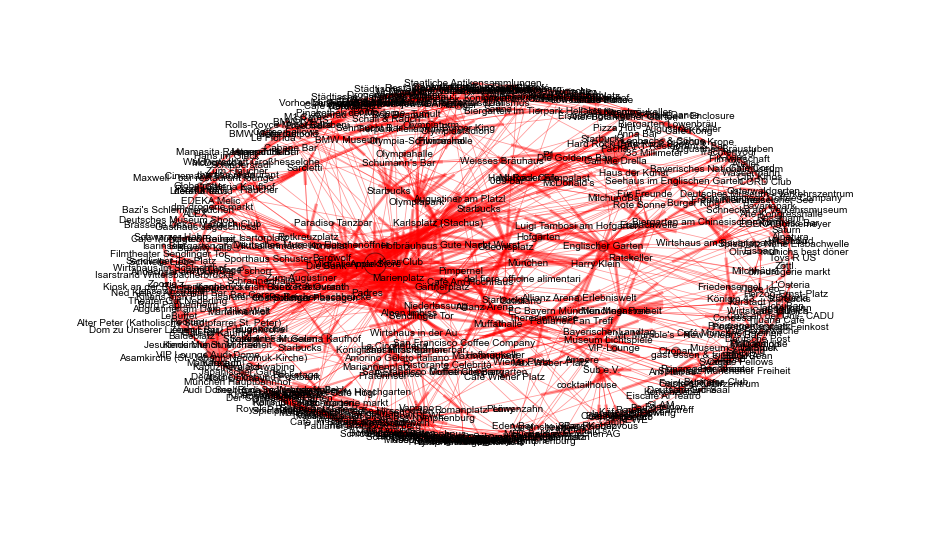

In [158]:
fig = plt.figure(figsize=(16, 9), dpi=150)
graph_pos=nx.spring_layout(F)
nodesize = [10000*n for n in pagerank_old.values()]
nx.draw_networkx_nodes(F,graph_pos,node_size=nodesize, alpha=0.5, node_color='red')
nx.draw_networkx_edges(F,graph_pos,width=0.8, alpha=0.4,edge_color='red')
nx.draw_networkx_labels(F, graph_pos, labels=venues_old["name"].to_dict(), font_size=10, font_family='Arial')
plt.axis('off')
plt.show()

Recreating the data set and populating the columns from the network data

In [263]:
venues_old = pd.DataFrame()
venues_old['name'] = nx.get_node_attributes(F,'name').values()
venues_old['checkins_may'] = nx.get_node_attributes(F,'visits').values()
venues_old['users_may'] = nx.get_node_attributes(F,'users').values()
venues_old['betweenness_may'] = nx.betweenness_centrality(F).values()
venues_old['pagerank_may'] = nx.pagerank(F,alpha=0.9,max_iter=200).values()
venues_old.index = nx.get_node_attributes(F,'name')

In [264]:
venues_old = venues_old.reset_index().drop_duplicates(cols='index',take_last=True).set_index('index')

Merging both datasets on the index (not on name - e.g. there are multiple Starbucks)

In [451]:
venues_both = venues.merge(venues_old, left_index=True, right_index=True)

Calculating the relative differences of our variables between May and July 2014

In [452]:
venues_both['checkins_delta'] = (venues_both['checkins']-venues_both['checkins_may'])/venues_both['checkins_may']
venues_both['betweenness_delta'] = (venues_both['betweenness']-venues_both['betweenness_may'])/venues_both['betweenness_may']
venues_both['pagerank_delta'] = (venues_both['pagerank']-venues_both['pagerank_may'])/venues_both['pagerank_may']

### Top 10 Locations with the largest increase in footfall (# checkins)

In [453]:
venues_both.sort('checkins_delta', ascending=False)[['name_x', 'checkins_may', 'checkins', 'checkins_delta']][:10]

name_x  checkins_may  \
index                                                                  
507d6e96498ec32f6e7bfa06  Spielplatz Nähe Eisbachwelle            40   
4bd44bfa046076b0fa967771                      Hirschau           693   
5246e0cc11d24223cc125f78                 Hans im Glück           732   
4c0b8af36071a5936b61e132                       Eisbach          1350   
51b37d63498eb9785e670720       Bazi's Schlemmerkucherl           163   
4bd1e0e1462cb7134215db07        Muffathalle Biergarten          1266   
4c6ec458e6b7b1f7c78fad8e                   Olympia Alm           488   
504260c7e4b04fbe5321813b                  Korkenzieher            32   
4d9865c361a3a1cd246ccc42       Amorino Gelato Italiano           166   
4ddc0e2d52b177ff2e6480b0          Sausalitos Sommerbar           102   

                          checkins  checkins_delta  
index                                               
507d6e96498ec32f6e7bfa06        64        0.600000  
4bd44bfa046076b0fa967771       850        0.226551  
5246e0cc11d24223cc125f78       889        0.214481  
4c0b8af36071a5936b61e132      1628        0.205926  
51b37d63498eb9785e670720       193        0.184049  
4bd1e0e1462cb7134215db07      1484        0.172196  
4c6ec458e6b7b1f7c78fad8e       571        0.170082  
504260c7e4b04fbe5321813b        37        0.156250  
4d9865c361a3a1cd246ccc42       191        0.150602  
4ddc0e2d52b177ff2e6480b0       117        0.147059

### Top 10 Locations with the largest increase in betweenness centrality

In [454]:
venues_both.sort('betweenness_delta', ascending=False)[['name_x', 'betweenness_may', 'betweenness', 'betweenness_delta']][:10]

name_x  \
index                                                                 
5246e0cc11d24223cc125f78                              Hans im Glück   
507ea5998acaf6098efe5fb5                                      BMW i   
4f68ba09e4b0551e6ca95cd0                                 Milka Welt   
4ade0d08f964a520636a21e3                                 Filmcasino   
4dcc250bd4c0dfa030e1120d                                 Königin 43   
4bf9444f8d30d13a47e50118                            Jessas Eisdiele   
4ade0cc8f964a520066921e3  Dom zu Unserer Lieben Frau | Frauenkirche   
4c23c5c6f1272d7ffaf681c5                             Filmwirtschaft   
4dce54fcd164679b8cfc787c                                 i love leo   
4bcfee37462cb71376a1d707                             Coffee Fellows   

                          betweenness_may  betweenness  betweenness_delta  
index                                                                      
5246e0cc11d24223cc125f78         0.000000     0.000735                inf  
507ea5998acaf6098efe5fb5         0.000000     0.002818                inf  
4f68ba09e4b0551e6ca95cd0         0.000000     0.017679                inf  
4ade0d08f964a520636a21e3         0.000000     0.000469                inf  
4dcc250bd4c0dfa030e1120d         0.000003     0.002818        1028.997386  
4bf9444f8d30d13a47e50118         0.000196     0.008775          43.817695  
4ade0cc8f964a520066921e3         0.002508     0.034780          12.865210  
4c23c5c6f1272d7ffaf681c5         0.000007     0.000095          11.972876  
4dce54fcd164679b8cfc787c         0.000141     0.001427           9.113625  
4bcfee37462cb71376a1d707         0.003693     0.036468           8.874570

### Top 10 Locations with the largest decrease in betweenness centrality

In [455]:
venues_both[venues_both.betweenness > 0].sort('betweenness_delta', ascending=True)[['name_x', 'betweenness_may', 'betweenness', 'betweenness_delta']][:10]

name_x  \
index                                                                        
4b8153bdf964a5209c9f30e3                    Kiosk an der Reichenbachbrücke   
4f3594dae4b08533d05103c8                                           Rubybar   
4b052a4df964a5204b5722e3                                         Starbucks   
4ade0cd2f964a520396921e3  Alter Peter (Katholische Stadtpfarrei St. Peter)   
4dbc66aa1e72b351cab229fd                                         Café Kong   
4b2b8d2bf964a5207ab724e3                                  Netzer & Overath   
4ade0cb0f964a520896821e3                                            Ampere   
4ade0c9bf964a5200e6821e3                               Wirtshaus in der Au   
4b113a3ff964a520127923e3                                            Kaimug   
4ade0d28f964a520196b21e3                              Olympia-Schwimmhalle   

                          betweenness_may  betweenness  betweenness_delta  
index                                                                      
4b8153bdf964a5209c9f30e3         0.243131     0.007391          -0.969599  
4f3594dae4b08533d05103c8         0.230612     0.009512          -0.958754  
4b052a4df964a5204b5722e3         0.000553     0.000025          -0.954765  
4ade0cd2f964a520396921e3         0.000678     0.000038          -0.943406  
4dbc66aa1e72b351cab229fd         0.013326     0.001420          -0.893461  
4b2b8d2bf964a5207ab724e3         0.244587     0.030052          -0.877132  
4ade0cb0f964a520896821e3         0.012437     0.001738          -0.860283  
4ade0c9bf964a5200e6821e3         0.019885     0.005790          -0.708823  
4b113a3ff964a520127923e3         0.000984     0.000315          -0.679800  
4ade0d28f964a520196b21e3         0.002836     0.000926          -0.673452

### Top 10 Locations with the largest increase in Pagerank

In [456]:
venues_both.sort('pagerank_delta', ascending=False)[['name_x', 'pagerank_may', 'pagerank', 'pagerank_delta']][:10]

name_x  pagerank_may  pagerank  \
index                                                                           
4ade0ccef964a520246921e3                  Marienplatz      0.003094  0.085931   
4b2135f8f964a520503824e3        Hard Rock Cafe Munich      0.000591  0.014885   
4ade0d29f964a520216b21e3                Allianz Arena      0.000982  0.023729   
4ade0cecf964a520cf6921e3                  Olympiaturm      0.000536  0.007821   
4b9536bff964a520bc9534e3                Rotkreuzplatz      0.000412  0.005999   
4b09134ef964a520281423e3                   McDonald’s      0.000591  0.007429   
4ade0cacf964a520736821e3                    Sarcletti      0.000406  0.004885   
4ae74e23f964a52038aa21e3                Niederlassung      0.000379  0.004547   
4fc5fc17e4b0c6d2d64b5357  FC Bayern München Megastore      0.000660  0.007901   
4ade0cdaf964a520666921e3                   BMW Museum      0.000642  0.007027   

                          pagerank_delta  
index                                     
4ade0ccef964a520246921e3       26.770680  
4b2135f8f964a520503824e3       24.174650  
4ade0d29f964a520216b21e3       23.162940  
4ade0cecf964a520cf6921e3       13.594360  
4b9536bff964a520bc9534e3       13.556653  
4b09134ef964a520281423e3       11.564500  
4ade0cacf964a520736821e3       11.036822  
4ae74e23f964a52038aa21e3       10.992942  
4fc5fc17e4b0c6d2d64b5357       10.969469  
4ade0cdaf964a520666921e3        9.950578

### Top 10 Locations with the largest decrease in PageRank

In [457]:
venues_both.sort('pagerank_delta', ascending=True)[['name_x', 'pagerank_may', 'pagerank', 'pagerank_delta']][:10]

name_x  pagerank_may  pagerank  \
index                                                               
4bc08b8d461576b0c4417a32         LeBuffet      0.015450  0.000804   
4b519094f964a520aa4f27e3           Wimmer      0.015555  0.000916   
4adf7208f964a520a07a21e3  Burg Pappenheim      0.004978  0.000890   
4bfa555f508c0f47c9f33f31   Zum Augustiner      0.025902  0.005384   
4ade0d08f964a520636a21e3       Filmcasino      0.002434  0.000536   
4baf75a8f964a52082013ce3   Riva Schwabing      0.005536  0.001249   
4b7aa67cf964a52061352fe3   Deutsche Eiche      0.005747  0.001318   
4b067d01f964a52043ec22e3      Cafe Munich      0.002158  0.000506   
4bd25fc7b221c9b63dacd7d0     Silans Kebap      0.003947  0.000971   
4dbc66aa1e72b351cab229fd        Café Kong      0.002485  0.000660   

                          pagerank_delta  
index                                     
4bc08b8d461576b0c4417a32       -0.947980  
4b519094f964a520aa4f27e3       -0.941118  
4adf7208f964a520a07a21e3       -0.821275  
4bfa555f508c0f47c9f33f31       -0.792146  
4ade0d08f964a520636a21e3       -0.779625  
4baf75a8f964a52082013ce3       -0.774352  
4b7aa67cf964a52061352fe3       -0.770728  
4b067d01f964a52043ec22e3       -0.765360  
4bd25fc7b221c9b63dacd7d0       -0.754060  
4dbc66aa1e72b351cab229fd       -0.734585

In [ ]:
Hotspots

In [458]:
venues_both.head()

checkins        lat        lng  \
index                                                      
4db9efd55da389d2c2303339       743  48.128940  11.576543   
4e49454d1f6e29f10dca054a      2937  48.134527  11.574656   
4dac08d60cb6a89c628e690a       235  48.130329  11.583377   
4b5b9d19f964a520040b29e3       868  48.131803  11.576211   
4b0ad1b6f964a520662823e3     18938  48.136874  11.574547   

                                                 name_x  users  pagerank  \
index                                                                      
4db9efd55da389d2c2303339                     Zephyr Bar    368  0.000564   
4e49454d1f6e29f10dca054a                 Schrannenhalle   1576  0.015118   
4dac08d60cb6a89c628e690a          Deutsches Museum Shop    178  0.000853   
4b5b9d19f964a520040b29e3  del fiore officine alimentari    559  0.001755   
4b0ad1b6f964a520662823e3                    Apple Store  10227  0.052095   

                          betweenness                         name_y  \
index                                                                  
4db9efd55da389d2c2303339     0.079590                     Zephyr Bar   
4e49454d1f6e29f10dca054a     0.020432                 Schrannenhalle   
4dac08d60cb6a89c628e690a     0.000000          Deutsches Museum Shop   
4b5b9d19f964a520040b29e3     0.000000  del fiore officine alimentari   
4b0ad1b6f964a520662823e3     0.046068                    Apple Store   

                          checkins_may  users_may  betweenness_may  \
index                                                                
4db9efd55da389d2c2303339           683        342         0.190142   
4e49454d1f6e29f10dca054a          2813       1508         0.002219   
4dac08d60cb6a89c628e690a           228        171         0.000000   
4b5b9d19f964a520040b29e3           807        522         0.000000   
4b0ad1b6f964a520662823e3         18621      10058         0.052891   

                          pagerank_may  checkins_delta  betweenness_delta  \
index                                                                       
4db9efd55da389d2c2303339      0.000431        0.087848          -0.581415   
4e49454d1f6e29f10dca054a      0.013223        0.044081           8.207843   
4dac08d60cb6a89c628e690a      0.000624        0.030702                NaN   
4b5b9d19f964a520040b29e3      0.001337        0.075589                NaN   
4b0ad1b6f964a520662823e3      0.048365        0.017024          -0.128992   

                          pagerank_delta  
index                                     
4db9efd55da389d2c2303339        0.309915  
4e49454d1f6e29f10dca054a        0.143315  
4dac08d60cb6a89c628e690a        0.366716  
4b5b9d19f964a520040b29e3        0.312735  
4b0ad1b6f964a520662823e3        0.077120

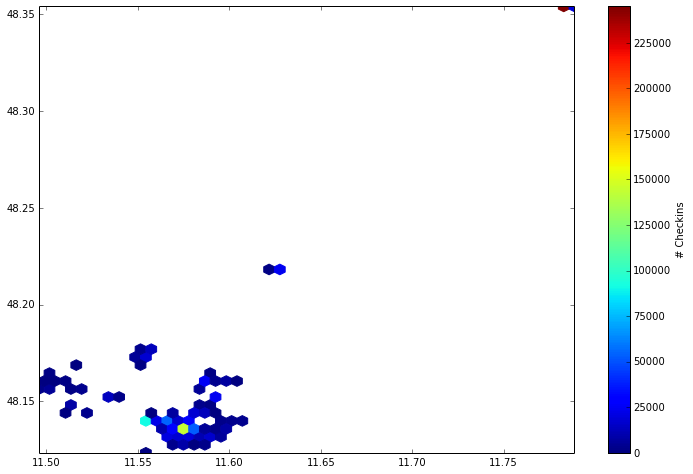

In [507]:
figure(figsize=(12,8)) 
plt.hexbin(venues.lng, venues.lat, gridsize=50, C=venues.checkins, reduce_C_function = np.sum)
cb = plt.colorbar()
cb.set_label('# Checkins')
plt.show()   

In [513]:
venues[venues.lng > 11.7]

checkins        lat        lng  \
index                                                      
4cbd1bfaf50e224b160503fc    244992  48.352599  11.780992   
4b90b43ff964a520df9433e3       746  48.354053  11.788584   
4e0569e06284d9ee92c8b000       513  48.353983  11.788284   
4f1ba985e4b035290e8d2ad5        48  48.353982  11.788082   
4fabab2de4b034d5346ae815       293  48.353987  11.787693   
4c4940ec20ab1b8d1aab8716      3832  48.354013  11.788097   
4b7912c0f964a520c8ea2ee3      3338  48.353854  11.788523   
4bacf0b6f964a5200c1c3be3      2344  48.353931  11.788532   
4b588c99f964a520675d28e3      6336  48.353982  11.788330   
4b696e03f964a520fca12be3      1153  48.353340  11.787751   

                                                                  name  users  \
index                                                                           
4cbd1bfaf50e224b160503fc  München Flughafen "Franz Josef Strauß" (MUC)  91098   
4b90b43ff964a520df9433e3                   Erdinger Weißbier Sportsbar    624   
4e0569e06284d9ee92c8b000                             FC Bayern Fanshop    355   
4f1ba985e4b035290e8d2ad5                             Backstube Wünsche     36   
4fabab2de4b034d5346ae815                                 Surf and Turf    185   
4c4940ec20ab1b8d1aab8716                        München Airport Center   2630   
4b7912c0f964a520c8ea2ee3                                     Starbucks   2061   
4bacf0b6f964a5200c1c3be3                                    McDonald's   1375   
4b588c99f964a520675d28e3                              Airbräu Brauhaus   4150   
4b696e03f964a520fca12be3                                         EDEKA    636   

                          pagerank  betweenness  
index                                            
4cbd1bfaf50e224b160503fc  0.000404     0.000000  
4b90b43ff964a520df9433e3  0.002281     0.000000  
4e0569e06284d9ee92c8b000  0.001052     0.000000  
4f1ba985e4b035290e8d2ad5  0.000974     0.000000  
4fabab2de4b034d5346ae815  0.000974     0.000000  
4c4940ec20ab1b8d1aab8716  0.002917     0.000012  
4b7912c0f964a520c8ea2ee3  0.003600     0.000029  
4bacf0b6f964a5200c1c3be3  0.003600     0.000079  
4b588c99f964a520675d28e3  0.003909     0.000115  
4b696e03f964a520fca12be3  0.003166     0.000150

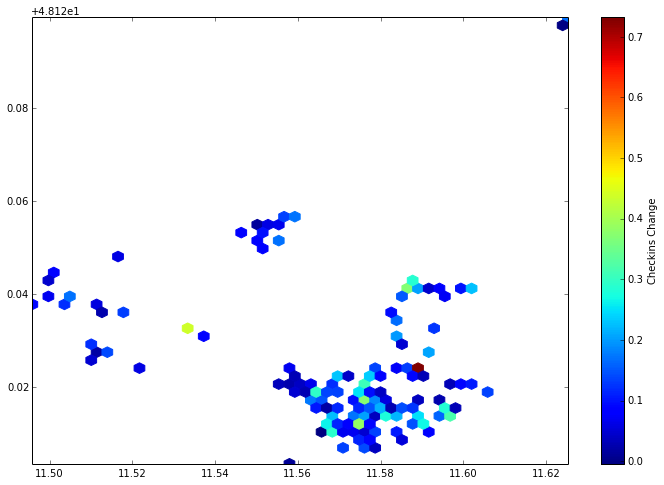

In [463]:
figure(figsize=(12,8)) 
plt.hexbin(venues_both.lng, venues_both.lat, gridsize=50, C=venues_both.checkins_delta, reduce_C_function = np.sum)
cb = plt.colorbar()
cb.set_label('Checkins Change')
plt.show()   

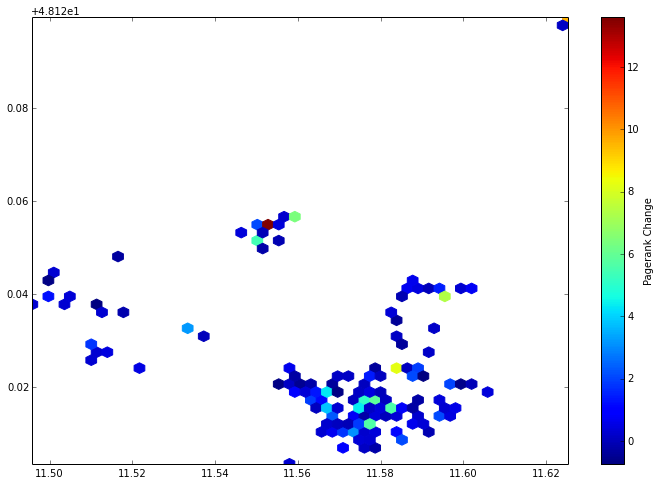

In [472]:
figure(figsize=(12,8)) 
plt.hexbin(venues_both.lng, venues_both.lat, gridsize=50, C=venues_both.pagerank_delta, reduce_C_function = np.mean)
cb = plt.colorbar()
cb.set_label('Pagerank Change')
plt.show()   

Rescaling the geodata to fit our basemap:<img src="http://upload.wikimedia.org/math/7/6/5/76512b142c1b7e27e8a7e7eb1fc11225.png">

In [645]:
venues_both['x'] = 1477*(venues_both.lng-11.455135345458984) / (11.626796722412108-11.455135345458984)
venues_both['y'] = 1040 - 1040*(venues_both.lat-48.113391315998626) / (48.194052718454039-48.113391315998626)
venues_both.sort('pagerank_delta', ascending=False)[['name_x', 'x', 'y', 'pagerank_delta', 'lat', 'lng']][:10]
venues_both = venues_both[venues_both.x >= 0 & (venues_both.y >= 0)]
venues_both.head()[['name_x', 'x', 'y']]

name_x            x  \
index                                                                  
4db9efd55da389d2c2303339                     Zephyr Bar  1044.608250   
4e49454d1f6e29f10dca054a                 Schrannenhalle  1028.370113   
4dac08d60cb6a89c628e690a          Deutsches Museum Shop  1103.411313   
4b5b9d19f964a520040b29e3  del fiore officine alimentari  1041.750467   
4b0ad1b6f964a520662823e3                    Apple Store  1027.438125   

                                   y  
index                                 
4db9efd55da389d2c2303339  839.521081  
4e49454d1f6e29f10dca054a  767.484438  
4dac08d60cb6a89c628e690a  821.609290  
4b5b9d19f964a520040b29e3  802.616195  
4b0ad1b6f964a520662823e3  737.227268

Plotting the data on an OpenStreetMap basemap that can be retrieved by

`render.openstreetmap.org/cgi-bin/export?bbox=11.455135345458984,48.113391315998626,11.626796722412108,48.194052718454039&scale=46176&format=png`

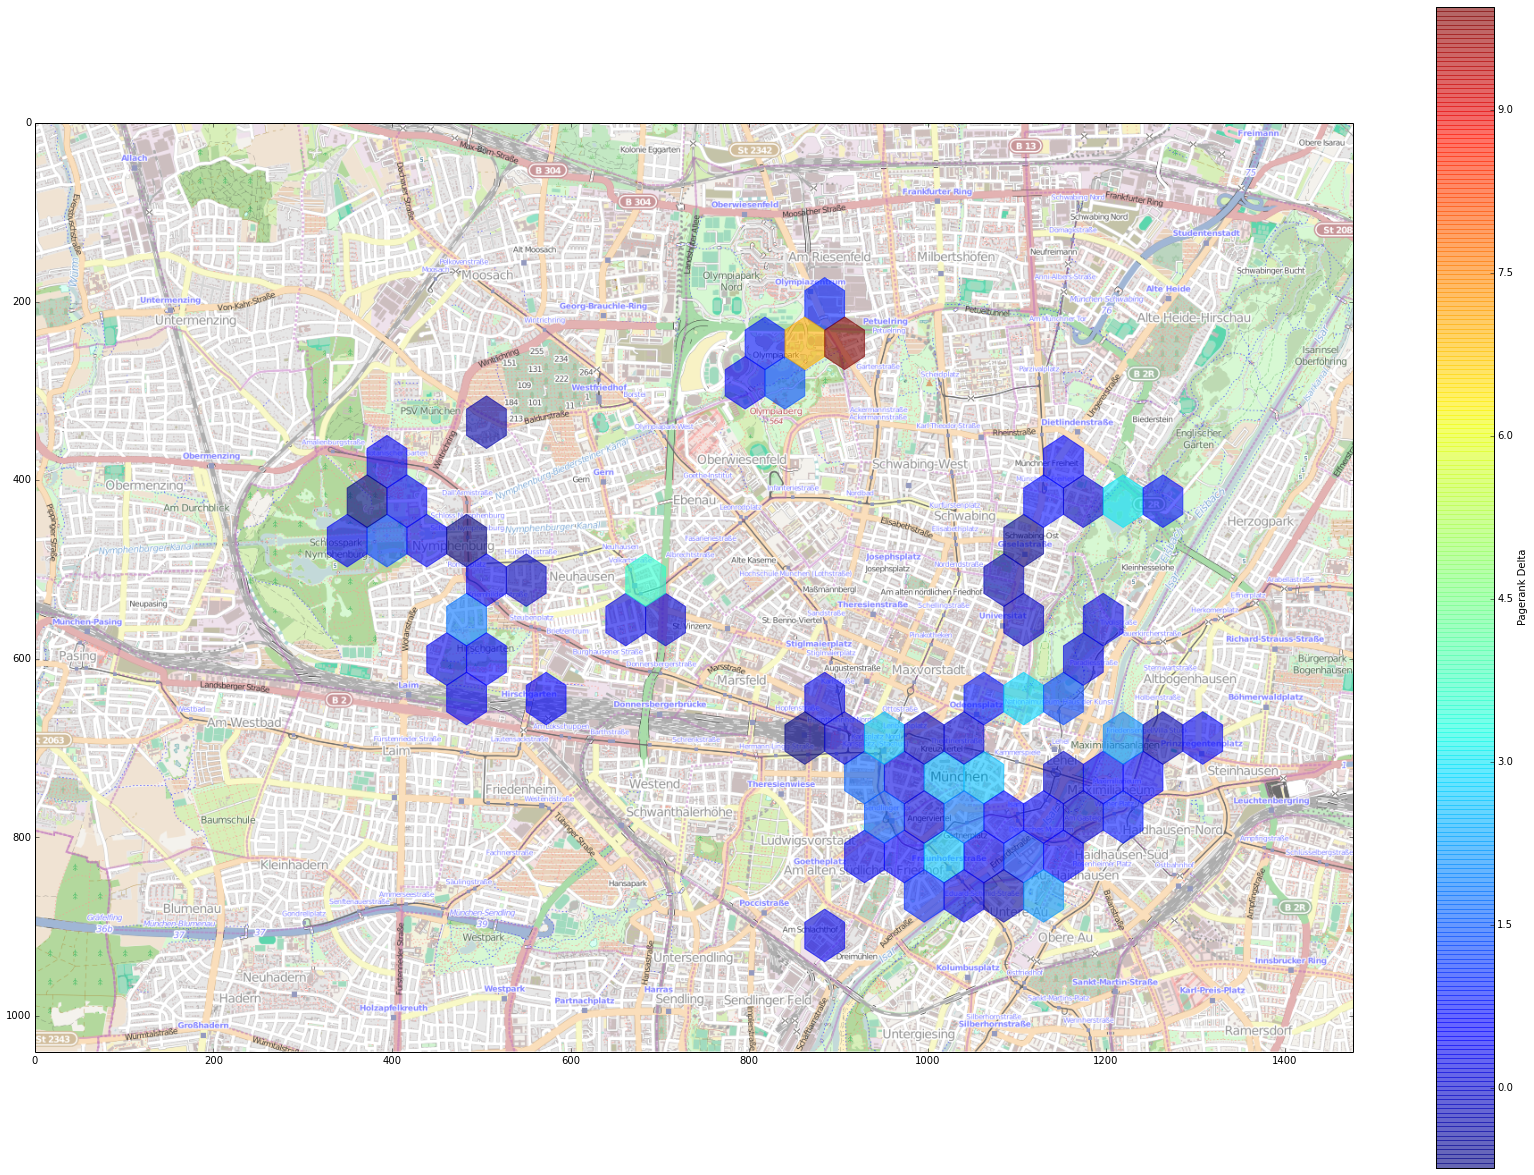

In [643]:
figure(figsize=(29.54,20.8)) 
img = imread("munich_osm.png")
plt.imshow(img, zorder=0, alpha=0.8)
plt.hexbin(venues_both.x, venues_both.y, gridsize=25, C=venues_both.pagerank_delta, reduce_C_function = np.mean, zorder=1, alpha=0.6)
plt.axis([0,1477,1040,0])
cb = plt.colorbar()
cb.set_label('Pagerank Delta')
plt.show()